In [46]:
import re
import random
import pandas as pd
import hashlib

In [47]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/2000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "CCH Tax Forms Project",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.127764; threshold=0.020723


In [48]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index() # type: ignore
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Simulacra, Dick",10.076958,10.076958,10.076958,1
Ansible,461.948868,11.548722,24.317480,40
ODBC,225.923213,14.120201,52.190114,16
Network Terms,247.890014,16.526001,55.334937,15
"Everything is Tuberculosis, Green",403.346820,17.536818,56.455093,23
Exchange Online and Defender,1314.915424,19.922961,185.910081,66
CCH Tax Forms Project,160.687349,26.781225,40.190507,6
"The Mines of the Behemoth, Shea",1314.588255,26.828332,153.546095,49
eDiscovery,1508.786888,28.467677,156.716993,53
WinHex,582.620596,29.131030,154.824330,20


# Histogram

sum of ages: ~24587.81


<Axes: >

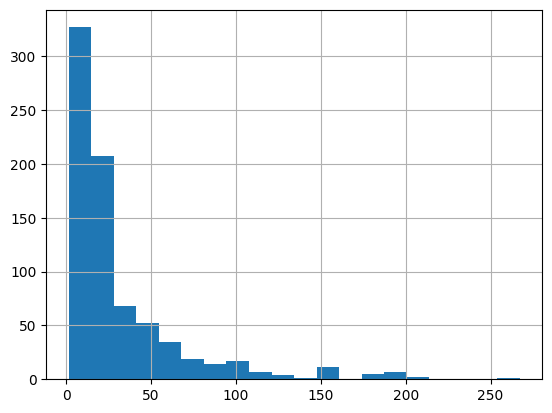

In [49]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~24587.81


<Axes: >

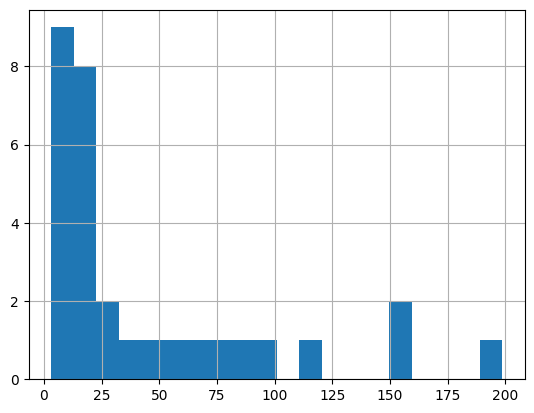

In [61]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Node.js and Vite']['age'].hist(bins=20)

# Completely Random Shuffle

In [51]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [52]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 777
Total card age: 24587.81


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
129,Microsoft Purview,"When viewed by users in your organization, an ...",9735b36099be5c4b66df7b3da4c7e94a,267.049327,43.310959,267.049327,1429.261634,0.834003,33
94,Docker,Compose Profiles\nEnable or disable optional s...,9b3012f07c186a9bcd20b86a12a77f0b,211.269307,37.512186,211.269307,1125.365592,0.036058,30
80,Terraform Codebox,Shebang (#!/bin/bash)\nThe first line in many ...,1e5d7b5c48fc5c9694191b41f91bae92,204.162164,37.758498,204.162164,1094.996446,0.512576,29
59,Windows PATH Variable,Duplicate Entries\nWhen the same directory app...,302556647410ce4ab20793e675f1b674,199.994180,34.883296,199.994180,906.965690,0.001115,26
101,Node.js and Vite,tailwind.config.js\nTells Tailwind where to lo...,f960b0747c547be5e142294c0e557df2,198.549714,44.976937,198.549714,1349.308099,0.260513,30
136,Azure Files Documentation,The Kerberos Key Distribution Center (KDC) is ...,2fe3be166485c1be2c565b9dc3725eeb,195.350588,43.606715,195.350588,1700.661896,0.048523,39
130,Microsoft Purview,Running a scan invokes the process to ingest m...,b83bea41722263bae12a4d077092b9f7,194.260740,43.310959,267.049327,1429.261634,0.834003,33
81,Terraform Codebox,curl -L -o filename\nA command to download fil...,9579c5ea9be6402b1e145491fbb73226,190.891028,37.758498,204.162164,1094.996446,0.512576,29
137,Azure Files Documentation,"In the OSI networking model, Microsoft SMB Pro...",a2af1bc565a17fa283e961a66d1487c0,190.618300,43.606715,195.350588,1700.661896,0.048523,39
87,SSH + SCP,PermitRootLogin (sshd)\nControls whether root ...,e7f28bc55845b01b2c16b5bc3f48b9c9,188.539692,30.362303,188.539692,880.506795,0.856600,29


# N-fold shuffle


## Age Sum

In [ ]:
# n = 3
## m = existing_cards.shape[0]//100
# m = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [54]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [55]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [56]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=existing_cards.shape[0]//100
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [57]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [58]:
existing_cards.head(10)['age'].sum()

np.float64(2040.6850399096786)

In [59]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
129,Microsoft Purview,"When viewed by users in your organization, an ...",9735b36099be5c4b66df7b3da4c7e94a,267.049327,43.310959,267.049327,1429.261634,0.834003,33
94,Docker,Compose Profiles\nEnable or disable optional s...,9b3012f07c186a9bcd20b86a12a77f0b,211.269307,37.512186,211.269307,1125.365592,0.036058,30
80,Terraform Codebox,Shebang (#!/bin/bash)\nThe first line in many ...,1e5d7b5c48fc5c9694191b41f91bae92,204.162164,37.758498,204.162164,1094.996446,0.512576,29
59,Windows PATH Variable,Duplicate Entries\nWhen the same directory app...,302556647410ce4ab20793e675f1b674,199.994180,34.883296,199.994180,906.965690,0.001115,26
101,Node.js and Vite,tailwind.config.js\nTells Tailwind where to lo...,f960b0747c547be5e142294c0e557df2,198.549714,44.976937,198.549714,1349.308099,0.260513,30
136,Azure Files Documentation,The Kerberos Key Distribution Center (KDC) is ...,2fe3be166485c1be2c565b9dc3725eeb,195.350588,43.606715,195.350588,1700.661896,0.048523,39
130,Microsoft Purview,Running a scan invokes the process to ingest m...,b83bea41722263bae12a4d077092b9f7,194.260740,43.310959,267.049327,1429.261634,0.834003,33
81,Terraform Codebox,curl -L -o filename\nA command to download fil...,9579c5ea9be6402b1e145491fbb73226,190.891028,37.758498,204.162164,1094.996446,0.512576,29
137,Azure Files Documentation,"In the OSI networking model, Microsoft SMB Pro...",a2af1bc565a17fa283e961a66d1487c0,190.618300,43.606715,195.350588,1700.661896,0.048523,39
87,SSH + SCP,PermitRootLogin (sshd)\nControls whether root ...,e7f28bc55845b01b2c16b5bc3f48b9c9,188.539692,30.362303,188.539692,880.506795,0.856600,29


In [60]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 31.645'